In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [28]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [29]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
class CustomContrastiveLoss(nn.Module): # my custom loss for my mental health
    def __init__(self, margin=1.0):
        super(CustomContrastiveLoss, self).__init__()
        self.margin = margin  # how far apart the dissimilar pairs should be pushed

    def forward(self, features, targets):
        positive_dist = torch.norm(features - targets, p=2, dim=1)

        # Euclidean distances for negative pairs and apply margin
        # For each target, calculate its distance to all other features and targets
        batch_size = features.shape[0]
        repulsion_loss = 0.0
        for i in range(batch_size):
            for j in range(batch_size):
                if i != j:
                    # Distance from target i to features j
                    dist_to_features = torch.norm(targets[i] - features[j], p=2)
                    # Distance from target i to targets j
                    dist_to_targets = torch.norm(targets[i] - targets[j], p=2)
                    # Apply margin and accumulate repulsion loss
                    repulsion_loss += F.relu(self.margin - dist_to_features) + F.relu(self.margin - dist_to_targets)

        # Mean over all pairs for both attraction and repulsion components
        attraction_loss = positive_dist.mean()
        repulsion_loss /= (batch_size * (batch_size - 1) * 2)  # Normalize by number of negative pairs

        # Total loss: minimize attraction while maximizing repulsion
        total_loss = attraction_loss + repulsion_loss

        return total_loss

In [31]:
def standardize_dataset(dataset):
    features = torch.vstack([dataset[i][0] for i in range(len(dataset))])
    targets = torch.vstack([dataset[i][1] for i in range(len(dataset))])
    print(features.shape)
    print(targets.shape)
    
    features_mean = features.mean(dim=0)
    features_std = features.std(dim=0)
    targets_mean = targets.mean(dim=0)
    targets_std = targets.std(dim=0)
    
    features_std[features_std == 0] = 1
    targets_std[targets_std == 0] = 1
    
    standardized_features = (features - features_mean) / features_std
    standardized_targets = (targets - targets_mean) / targets_std
    
    standardized_dataset = TensorDataset(standardized_features, standardized_targets)
    
    return standardized_dataset

In [32]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy")

In [33]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size = 0.2, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [34]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 59
# the rest is arbitrary
hidden_dim_feat = 1000
hidden_dim_target = 24
output_dim = 2
num_epochs = 1000


In [35]:
temperature = 0.5
base_temperature = 0.5 # too low values return nan loss
lr = 0.001 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 10 # too low values return nan loss

In [36]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([117, 499500])
torch.Size([117, 59])
torch.Size([30, 499500])
torch.Size([30, 59])


In [37]:

model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
# criterion = KernelizedSupCon(method='expw', temperature=temperature, base_temperature=base_temperature, kernel=kernel, delta_reduction = 'mean')
criterion = CustomContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat, out_target = model(features, targets)
        loss = criterion(out_feat, out_target)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)


Epoch 0 | Mean Loss 1.2387079099814098
Epoch 1 | Mean Loss 1.042456070582072
Epoch 2 | Mean Loss 0.9415024866660436
Epoch 3 | Mean Loss 0.9989824891090393


KeyboardInterrupt: 

In [ ]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [12]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [20]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   1.35


In [21]:
emb_features = torch.row_stack(emb_features)

In [22]:
emb_targets = torch.row_stack(emb_targets)

In [23]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [24]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [25]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

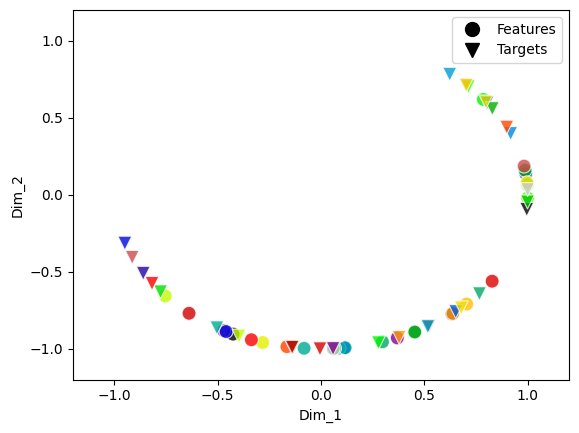

In [26]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])

## Learning curve

In [29]:
from estimators import TargetEstimator
from utils_v import gather_feats_targets

X_train, y_train = gather_feats_targets(model, std_train_loader, device)
X_test, y_test = gather_feats_targets(model, std_test_loader, device)


In [30]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [31]:
estimator = TargetEstimator()

In [32]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


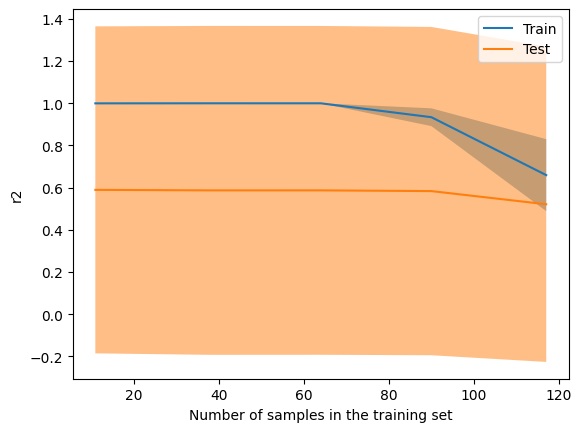

In [33]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
